In [1]:
import os, sys, numpy as np, glob, matplotlib, scipy, healpy
%matplotlib inline
from matplotlib import pyplot

In [4]:
filedict = {'numu': glob.glob("/data/user/apizzuto/Nova/skylab_dataset/output/numu/*[0-9].npy"),
            'nutau': glob.glob("/data/user/apizzuto/Nova/skylab_dataset/output/nutau/*[0-9].npy"),
            'nue': glob.glob("/data/user/apizzuto/Nova/skylab_dataset/output/nue/*[0-9].npy"),
            'data': glob.glob("/data/user/apizzuto/Nova/skylab_dataset/output/data/*[0-9].npy"),
           }

for key in filedict.keys():
    print key, len(filedict[key])

numu 98
nue 100
data 98
nutau 98


In [5]:
class map_stream:
    fnames = []
    findex = 0
    index = 0
    current = None
    
    def __init__(self, filenames):
        self.fnames = sorted(filenames)
        self.index = 0
        self.findex = 0
        self.current = np.load(self.fnames[self.findex])
        
    def next(self):
        event = None
        if len(current) <= self.index:
            self.findex += 1
            self.index = 0
            if self.findex > len(self.fnames):
                print("No more files or events to load.")
                return None
            self.current = np.load(self.fnames[self.findex])
        event = self.current[i]
        return current
    
def merge_files(filenames):
    filenames.sort()
    x = np.load(filenames[0])
    for f in filenames[1:]:
        y = np.load(f)
        if 'ow' in x.dtype.names:
            if not 'trueDeltaLLH' in y.dtype.names: continue
        x = np.concatenate([x, y])
    return x


results = {}
maps = {}
for key in filedict:
    results[key] = merge_files(filedict[key])
    maps[key] = map_stream(filedict[key])

    if 'ow' in results[key].dtype.names:
        results[key]['ow'] /= len(filedict[key])
    print key, results[key].shape


numu (325719,)
nue (384676,)
data (959572,)
nutau (761630,)


In [34]:
# Merge the neutrinos into one set
neutrinos = np.copy(results['numu'])
for flavor in ['nue', 'nutau']:
    neutrinos = np.concatenate([neutrinos, results[flavor]])
    
# Save it
#np.save(open("IC86_2018_MC.npy", 'w'), neutrinos)
#np.save(open("IC86_2012-2018_Data.npy", 'w'), results['data'])

In [35]:
# calculate the median for each
def get_percentiles(x, y, weights, bins, percentile=0.68):
    output = np.zeros_like(ebins[:-1])

    for i in range(ebins.shape[0]-1):
        emin, emax = ebins[i], ebins[i+1]
        mask = (x>=emin) & (x<emax)
        if mask.sum()==0: continue

        # Make a cumulative plot
        h, b = np.histogram(y[mask], weights=weights[mask], bins=1000)
        h = np.cumsum(h)/np.sum(h)
        
        # Find the right percentile
        j = np.searchsorted(h, percentile,)-1
        output[i] = b[j]

    return output



43.61754388908789
43.48249427130814
43.32663837597052


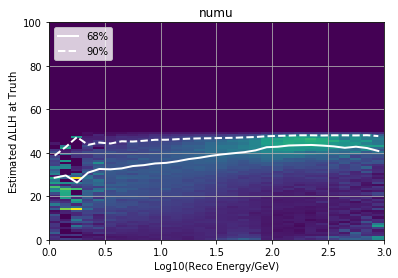

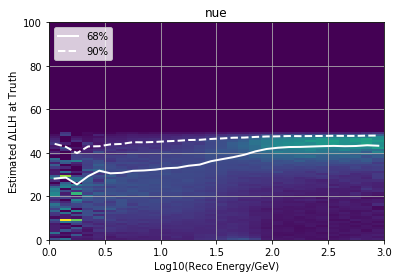

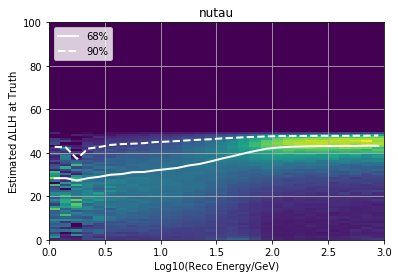

In [36]:
ebins = np.linspace(0, 3, 31)
#ebins = np.log10(np.arange(1.11, 200, 2.22) )

for key in results.keys():
    if key == 'data': continue
        
    dllh = results[key]['trueDeltaLLH']
    results[key]['trueDeltaLLH'][dllh > 1000] = 1000

    fig, ax = pyplot.subplots()
    w = 800*results[key]['ow'] * results[key]['trueE']**-3.7
    h, xedges, yedges = np.histogram2d(results[key]['logE'],
                                      results[key]['trueDeltaLLH'],
                                      bins = (ebins,
                                              np.linspace(0, 100, 101)),
                                      weights = w)

    # Normalize along each column
    for i in range(h.shape[0]):
        h[i] /= np.sum(h[i])
    ax.pcolormesh(xedges, yedges, h.T)

        
    one_sigma_pulls = get_percentiles(results[key]['logE'],
                                      results[key]['trueDeltaLLH'], 
                                      w, np.linspace(0, 4, 21), 
                                      percentile=0.68)
    one_sigma_pulls[one_sigma_pulls > yedges.max()] = yedges.max()
    ax.plot(ebins[:-1]+np.diff(ebins)/2.0,
            one_sigma_pulls,
           color = 'w', linewidth=2,
           label = '68%')
    print np.max(one_sigma_pulls)

    
    two_sigma_pulls = get_percentiles(results[key]['logE'],
                                      results[key]['trueDeltaLLH'], 
                                      w, np.linspace(0, 4, 21), 
                                      percentile=0.95)
    two_sigma_pulls[two_sigma_pulls > yedges.max()] = yedges.max()
    ax.plot(ebins[:-1]+np.diff(ebins)/2.0,
            two_sigma_pulls,
            color = 'w', linewidth=2,
            linestyle = 'dashed',
            label = '90%')

    ax.grid()
    ax.legend(loc='upper left')
    ax.set_xlabel("Log10(Reco Energy/GeV)")
    ax.set_ylabel(r'Estimated $\Delta$LLH at Truth')
    ax.set_title(key)

30.0


Text(0.5,1,'All Neutrinos')

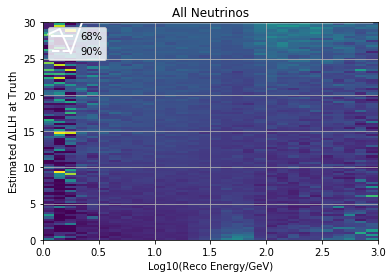

In [37]:
ebins = np.linspace(0, 3, 31)

dllh = neutrinos['trueDeltaLLH']
neutrinos['trueDeltaLLH'][dllh > 1000] = 1000

fig, ax = pyplot.subplots()
w = 800*neutrinos['ow'] * neutrinos['trueE']**-3.7
h, xedges, yedges = np.histogram2d(neutrinos['logE'],
                                  neutrinos['trueDeltaLLH'],
                                  bins = (ebins,
                                          np.linspace(0, 30, 101)),
                                  weights = w)

# Normalize along each column
for i in range(h.shape[0]):
    h[i] /= np.sum(h[i])
ax.pcolormesh(xedges, yedges, h.T)

one_sigma_pulls = get_percentiles(neutrinos['logE'],
                                  neutrinos['trueDeltaLLH'], 
                                  w, np.linspace(0, 4, 21), 
                                  percentile=0.68)
one_sigma_pulls[one_sigma_pulls > yedges.max()] = yedges.max()
ax.plot(ebins[:-1]+np.diff(ebins)/2.0,
        one_sigma_pulls,
       color = 'w', linewidth=2,
       label = '68%')
print np.max(one_sigma_pulls)


two_sigma_pulls = get_percentiles(neutrinos['logE'],
                                  neutrinos['trueDeltaLLH'], 
                                  w, np.linspace(0, 4, 21), 
                                  percentile=0.95)
two_sigma_pulls[two_sigma_pulls > yedges.max()] = yedges.max()
ax.plot(ebins[:-1]+np.diff(ebins)/2.0,
        two_sigma_pulls,
        color = 'w', linewidth=2,
        linestyle = 'dashed',
        label = '90%')

ax.grid()
ax.legend(loc='upper left')
ax.set_xlabel("Log10(Reco Energy/GeV)")
ax.set_ylabel(r'Estimated $\Delta$LLH at Truth')
ax.set_title('All Neutrinos')

Text(0,0.5,'Rate ($E^{-3.7}$, arbitrary scale)')

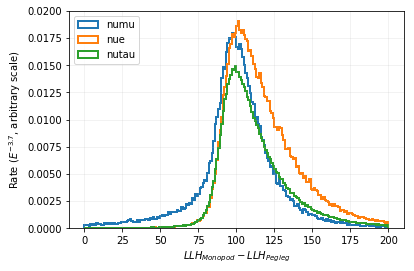

In [38]:
fig, ax = pyplot.subplots()
for key in results.keys():
    if 'data' in key: continue
    mask = results[key]['trueE'] > 50
    
    w = 800*results[key]['ow'] * results[key]['trueE']**-3.7
    dllh_bins = np.linspace(0, 200, 201)
    ax.hist(results[key]['pidDeltaLLH'][mask],
            bins=dllh_bins,
            weights = w[mask],
            label = key,
            linewidth = 2,
           histtype='step',)
    
ax.grid(alpha=0.2)
ax.legend(loc='upper left')
ax.set_xlabel(r'$LLH_{Monopod}-LLH_{Pegleg}$')
ax.set_ylabel(r'Rate ($E^{-3.7}$, arbitrary scale)')
#ax.set_yscale('log')

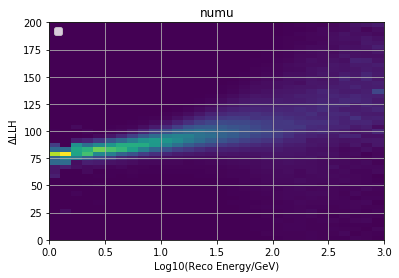

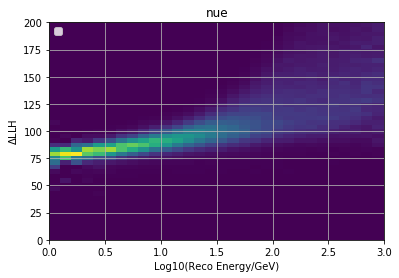

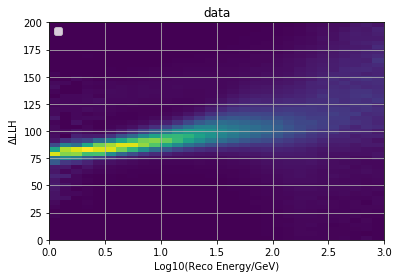

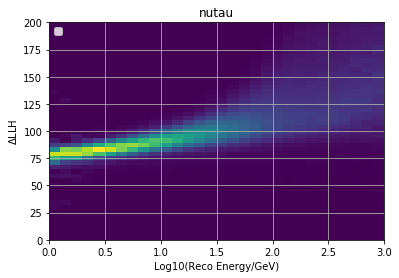

In [39]:
for key in results.keys():
    fig, ax = pyplot.subplots()
    if 'ow' in results[key].dtype.names:
        w = 800*results[key]['ow'] * results[key]['trueE']**-3.7
    else:
        w = None
    dllh_bins = np.concatenate([-np.logspace(1, 3, 25)[::-1],
                                np.logspace(1, 3, 5)])
    h, xedges, yedges = np.histogram2d(results[key]['logE'],
                                      results[key]['pidDeltaLLH'],
                                      bins = (ebins,
                                              np.linspace(0, 200, 50)),
                                      weights = w)
    h = h.astype(float)
    for i in range(h.shape[0]):
        tot = np.sum(h[i])
        if tot == 0: continue
        h[i] /= tot
        
    ax.pcolormesh(xedges, yedges, h.T)
    
    ax.grid()
    ax.legend(loc='upper left')
    ax.set_xlabel("Log10(Reco Energy/GeV)")
    ax.set_ylabel(r'$\Delta$LLH')
    ax.set_title(key)


('run', 'event', 'subevent', 'time', 'ra', 'dec', 'azi', 'zen', 'angErr', 'logE', 'monopod_azi', 'monopod_zen', 'pidDeltaLLH', 'pidPeglegLLH', 'pidMonopodLLH', 'pidLength', 'trueE', 'trueRa', 'trueDec', 'ow', 'ptype', 'iscc', 'trueDeltaLLH')
('run', 'event', 'subevent', 'time', 'ra', 'dec', 'azi', 'zen', 'angErr', 'logE', 'monopod_azi', 'monopod_zen', 'pidDeltaLLH', 'pidPeglegLLH', 'pidMonopodLLH', 'pidLength', 'trueE', 'trueRa', 'trueDec', 'ow', 'ptype', 'iscc', 'trueDeltaLLH')


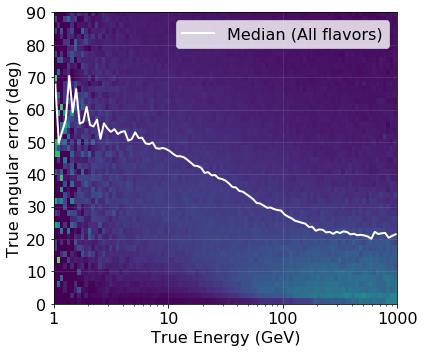

In [40]:
print neutrinos.dtype.names
true_dist = healpy.rotator.angdist([np.rad2deg(neutrinos['ra']), 
                                    np.rad2deg(neutrinos['dec'])],
                                   [np.rad2deg(neutrinos['trueRa']), 
                                    np.rad2deg(neutrinos['trueDec'])],
                                   lonlat = True
                                  )

bins = [-90, -60, -30, 0, 30, 60, 90]
ebins = np.logspace(0, 3, 100)

# pick some weights
w = neutrinos['ow'] * neutrinos['trueE']**-3.7
w *= 2.2e-3 / np.sum(w) 
w *= 7 * 365.42*24*3600 * 0.95

print neutrinos.dtype.names

fig, ax1 = pyplot.subplots(1, 1, figsize=(6, 5))

h, x, y = np.histogram2d(neutrinos['trueE'],
                      np.rad2deg(true_dist),
                      weights = w,
                      bins = [ebins, 
                              np.linspace(0, 180, 100)])

for i in range(h.shape[0]):
    h[i] /= np.sum(h[i])

cmesh = ax1.pcolormesh(x, y, h.T)

median = get_percentiles(neutrinos['trueE'],
                         np.rad2deg(true_dist), 
                         w,
                         ebins,
                         percentile=0.50)
ax1.plot(ebins[:-1]+np.diff(ebins)/2.0,
        median,
       color = 'w', linewidth=2,
       label = 'Median (All flavors)')

ax1.grid(alpha=0.2)
ax1.set_ylim(0, 90)
ax1.set_xlim(1, 1000)
ax1.legend(fontsize=16,)
ax1.set_xscale('log')
ax1.set_ylabel("True angular error (deg)", fontsize=16,)
ax1.set_xticklabels([0.1, 1, 10, 100, 1000], fontsize=16)
ax1.set_yticklabels(np.linspace(0, 90, 10, dtype=int), fontsize=16)
ax1.set_xlabel("True Energy (GeV)", fontsize=16)
fig.tight_layout()


In [47]:
from matplotlib.colors import LogNorm

('run', 'event', 'subevent', 'time', 'ra', 'dec', 'azi', 'zen', 'angErr', 'logE', 'monopod_azi', 'monopod_zen', 'pidDeltaLLH', 'pidPeglegLLH', 'pidMonopodLLH', 'pidLength', 'trueE', 'trueRa', 'trueDec', 'ow', 'ptype', 'iscc', 'trueDeltaLLH')
[-16. -14. -12.  12.  14.  16.]



345087
\nu_\e$ CC 186233.4219383265


29.0
295464
\nu_\mu$ CC 205218.71598818776


29.0
578939
\nu_\tau$ CC 35151.29857533482




/home/apizzuto/.venvs/nova/lib/python2.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in divide


nan


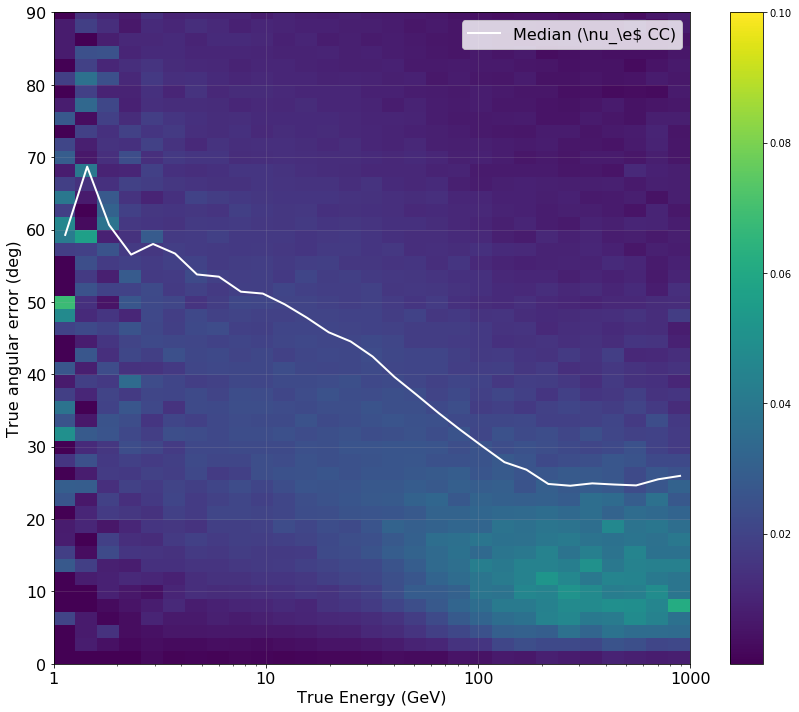

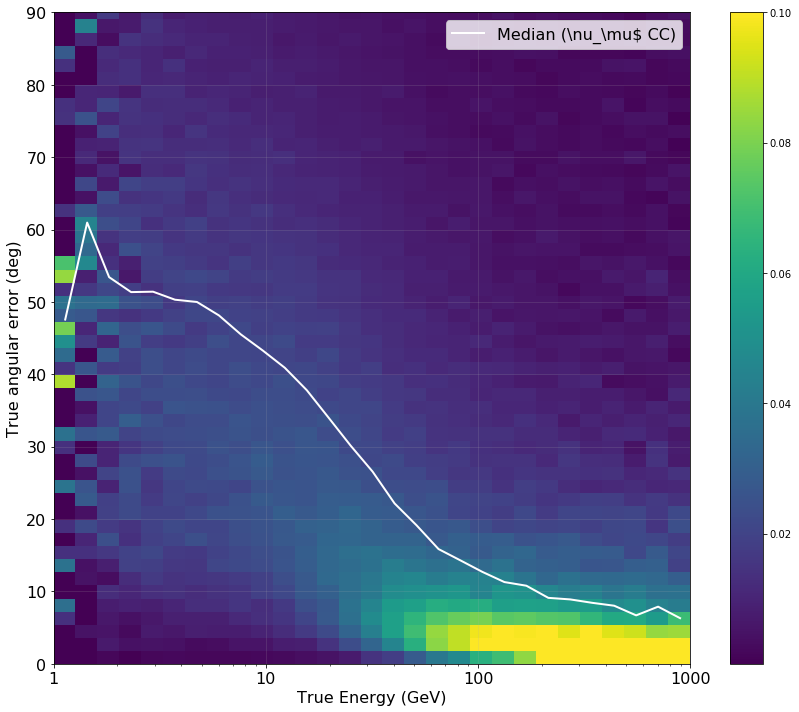

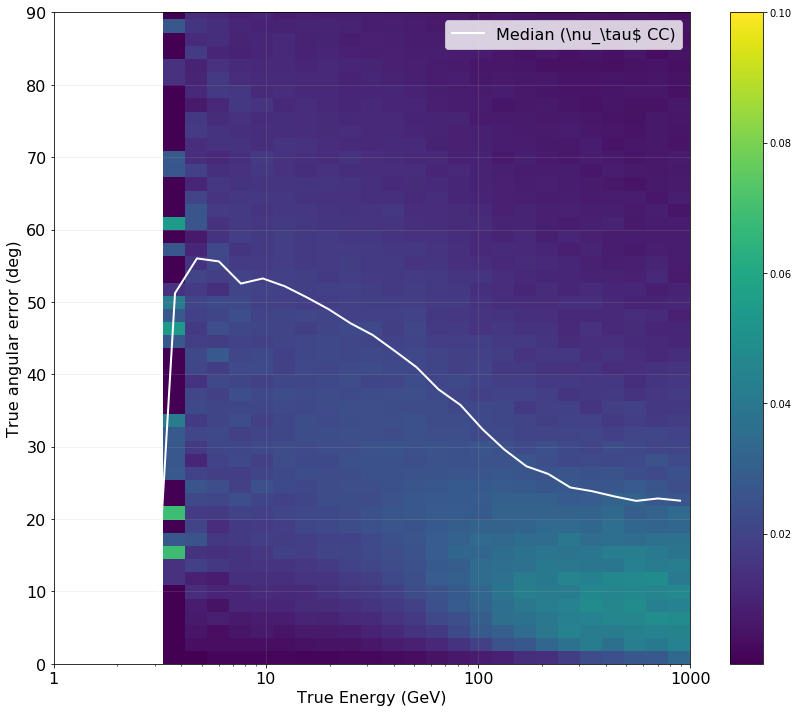

In [52]:
print neutrinos.dtype.names
true_dist = healpy.rotator.angdist([np.rad2deg(neutrinos['ra']), 
                                    np.rad2deg(neutrinos['dec'])],
                                   [np.rad2deg(neutrinos['trueRa']), 
                                    np.rad2deg(neutrinos['trueDec'])],
                                   lonlat = True
                                  )

bins = [-90, -60, -30, 0, 30, 60, 90]
ebins = np.logspace(0, 3, 30)

# pick some weights
w = neutrinos['ow'] * neutrinos['trueE']**-3.7
w *= 2.2e-3 / np.sum(w) 
w *= 7 * 365.42*24*3600 * 0.95

print np.unique(neutrinos['ptype'])
print '\n\n'

for flavor, ptype in [[r'\nu_\e$ CC', 12],
                     [r'\nu_\mu$ CC', 14],
                     [r'\nu_\tau$ CC', 16],]:
    
    fig, ax1 = pyplot.subplots(1, 1, figsize=(12, 10))
    mask = neutrinos['iscc'].copy()
    mask &= np.abs(neutrinos['ptype']).astype(int) == ptype
    print np.sum(mask)
    print flavor, np.sum(w[mask])
    print '\n'
    
    h, x, y = np.histogram2d(neutrinos['trueE'][mask],
                          np.rad2deg(true_dist)[mask],
                          weights = w[mask],
                          bins = [ebins, 
                                  np.linspace(0, 180, 100)])

    for i in range(h.shape[0]):
        h[i] /= np.sum(h[i])

    cmesh = ax1.pcolormesh(x, y, h.T, vmin = 1e-5, vmax=0.1)
    fig.colorbar(cmesh)

    median = get_percentiles(neutrinos['trueE'][mask],
                             np.rad2deg(true_dist)[mask], 
                             w[mask],
                             ebins,
                             percentile=0.50)
    ax1.plot(ebins[:-1]+np.diff(ebins)/2.0,
            median,
           color = 'w', linewidth=2,
           label = 'Median ('+flavor+')')
    
    print np.sum(h)

    ax1.grid(alpha=0.2)
    ax1.set_ylim(0, 90)
    ax1.set_xlim(1, 1000)
    ax1.legend(fontsize=16,)
    ax1.set_xscale('log')
    ax1.set_ylabel("True angular error (deg)", fontsize=16,)
    ax1.set_xticklabels([0.1, 1, 10, 100, 1000], fontsize=16)
    ax1.set_yticklabels(np.linspace(0, 90, 10, dtype=int), fontsize=16)
    ax1.set_xlabel("True Energy (GeV)", fontsize=16)
    fig.tight_layout()


In [44]:
?ax1.pcolormesh